# Auto Differentiation
Based on _Murphy(2025)_ and [this article](https://thenumb.at/Autodiff/#many-to-many)

Overall a __optimization__ problem can be seen as $$\theta^* \in \underset{\theta \in \Theta}{\arg\min}\mathcal{L}(\theta)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4.5, 3)

## Differentiation


#### _Numerical_
The mosth straightforward technique: simply approximates the definition of the derivative
$$f'(x)=\lim_{h\rightarrow0}\frac{f(x+h)-f(x)}{h}$$
Choosing a small $h$ then we evaluate $f$ at $x$ and $x+h$. Known as _finite dfiferences_

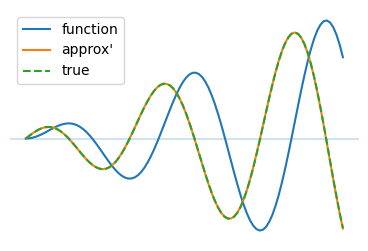

In [48]:
def numerical_diff(f, h): # known as the forward difference
    def derivative(x):
        return (f(x + h) - f(x)) / h
    return derivative

def cos(x):
    return x * np.sin(x)

def true_dif(x):
    return np.sin(x) + x*np.cos(x)

fp = numerical_diff(cos, 0.01)
x_ = np.linspace(0, 15, 100)

plt.plot(x_, cos(x_), label='function') 
plt.plot(x_, fp(x_), label="approx'")
plt.plot(x_, true_dif(x_), '--',label='true')
plt.axhline(0, alpha=0.2)
plt.legend()
plt.axis(False);

This only compute the derivative of $f$ in one direction. If input is very high computing full gradient of $f$ becomes computionally infeasible as we would have to evaluate $f$ for each dimension separetely

#### _Symbolic_
Involves transforming a representation of $f$ into a representation of $f'$. this requires $f$ in a domain-specific language each syntactic construct has a known differentiation rule (the classic approach).

Mathematica use this, we can create a simple language of polynomial that is symbolically differentiable using a small set of recursive rules

x*cos(x) + sin(x)

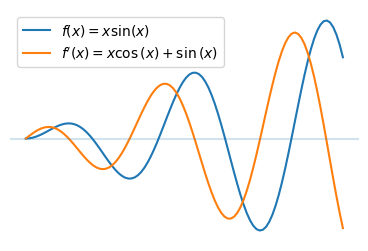

In [3]:
from sympy import symbols, diff as symdiff, lambdify
import sympy

# try to implement it from scratch is just annoying
x = symbols('x')
f = x * sympy.sin(x)
f_prime = symdiff(f, x)
f_np = lambdify(x, f, 'numpy')     
f_prime_np = lambdify(x, f_prime, 'numpy')  # make callables

plt.plot(x_, f_np(x_), label=r"$f(x) = x \sin(x)$")
plt.plot(x_, f_prime_np(x_), label=rf"$f'(x) = {sympy.latex(f_prime)}$")
plt.axhline(0, alpha=0.2)
plt.legend()
plt.axis(False);
f_prime

If made from scratch we would need to add more differentiation rules, but there is a catch: the size of $f'$s representation can become very large so differentiating an expression cannot decrease the number of terms, which is acceptable if the size of `df` is linear in the size of `f` but that's not the case

#### _Autodifferentiation_


The modern autodiff algorithm used in modern programming has two __flavors__, each named for the direction in which it computes derivatives
##### _Forward mode_
This mode improves on our two older techniques by computing exact derivatives without building a potentially exponentially-large expression of $f'$. Is based on _dual numbers_

_Dual numbers_

Are a bit like complex numbers; defined by adjoining a new quantity $\epsilon$ to the reals. But unlike complex numbers $i^2=-1$, dual are $\epsilon^2=0$.

In particular, we can use the $\epsilon$ part of the dual number to represent the derivative of the scalar part. Replacing each variable $x$ with $x+x\epsilon$, we'll find the dual arithmetic naturally expresess how derivatives combine _see Algorithms for optimization_

In [4]:
class ForwardMode:
    def __init__(self, real, dual=0):
        """
        Initialize a dual number for forward-mode AD.
            real: The primal value (function value).
            dual: The tangent (derivative value). Defaults to 0.
        """
        self.real = real  # function value (f(x))
        self.dual = dual  # derivative (f'(x))

    def __repr__(self):
        return f"ForwardMode(real={self.real}, dual={self.dual})"

    def __add__(self, other):
        """
        Add two ForwardMode objects or a ForwardMode with a constant.
        """
        if isinstance(other, ForwardMode):
            return ForwardMode(self.real + other.real, self.dual + other.dual)
        else:
            return ForwardMode(self.real + other, self.dual)  # dual part of constant is 0

    def __mul__(self, other):
        """
        Multiply two ForwardMode objects or a ForwardMode with a constant.
        Implements the product rule.
        """
        if isinstance(other, ForwardMode):
            return ForwardMode(
                self.real * other.real,
                self.real * other.dual + self.dual * other.real  #prroduct rule
            )
        else:
            return ForwardMode(self.real * other, self.dual * other)  # linearity for constants

    def __sub__(self, other):
        if isinstance(other, ForwardMode):
            return ForwardMode(self.real - other.real, self.dual - other.dual)
        else:
            return ForwardMode(self.real - other, self.dual)

    def __truediv__(self, other):
        if isinstance(other, ForwardMode):
            return ForwardMode(
                self.real / other.real,
                (self.dual * other.real - self.real * other.dual) / (other.real ** 2)  # Quotient rule
            )
        else:
            return ForwardMode(self.real / other, self.dual / other)

    def sin(self):
        """Compute sine of the dual number."""
        return ForwardMode(np.sin(self.real), np.cos(self.real) * self.dual)

    def exp(self):
        """Compute exponential of the dual number."""
        exp_real = np.exp(self.real)
        return ForwardMode(exp_real, exp_real * self.dual)
    
x = ForwardMode(3, 1)  # seed with dual=1 to compute df/dx
f = x * x + x.sin()
print(f) 

import torch
x = torch.tensor(3.0, requires_grad=True)
f = x ** 2 + torch.sin(x)
f.backward()  # Compute df/dx

print("\nPyTorch (Reverse-Mode):")
print(f"f(3)  = {f.item():.5f}")       # Output: 9.14112
print(f"f'(3) = {x.grad.item():.5f}")  # Output: 5.01001

ForwardMode(real=9.141120008059866, dual=5.010007503399555)

PyTorch (Reverse-Mode):
f(3)  = 9.14112
f'(3) = 5.01001


The `dual` part tracks the derivative of the computation part, while forward-mode autodiff does compute exact derivatives, it suffers from the same fundamental problem as finite differences: each invocation of $f$ can only compute the directional derivative of $f$ for a single direction.

Unfortunately, optimization problems in machine learning and graphics often have the opposite structure: $f$ have a huge number of inputs (e.g. the coefficients of a 3D scene or a NN) and a single output. That is, $\nabla f$ has many columns and few rows.

##### _Backward mode_
Backward mode provides a way to compute a row of the gradient using a single invocation of $f$. So this is the way to optimizng many-to-one functions. This make the __full gradient in one pass__

With Leibniz's notation $f'(x)=\frac{\partial f}{\partial x}$. The chain rule is written as $$g(f(x))'=\frac{\partial g}{\partial f}\cdot\frac{\partial f}{\partial x}=\frac{\partial g}{\partial x}$$

##### _Backpropagation_
Similarly to how forward-mode autodiff propagated derivatives from inputs to outputs, backward-mode propagates derivatives from outputs to inputs.

We dont know what the gradient of our input should be before evaluating the rest of the function, when evaluating $f$ we use each operation to build a _computational graph_ that represents $f$. That is, when $f$ tells us to perform a operation, we create a new node nothin what the operation is and connect it to the nodes representing its inputs, a pure function can be represented as a directed acyclic graph (or DAG).

We always have to evaluate all outputs of a node before the node itself, we only have to check each node once. WE may traverse the graph in _reverse topological order_

Traversing the graph built up a derivative term for each path from an input to the output. In _essence_, backprop is the chain rule upgraded with dynamic programming. The whole algorithm has the same time complexity as $f$ itself.


f(x) = 0.022869105813018625, expected: 0.022869105813018625 at idx=1
f'(x) = 0.3007154198291085, expected: 0.3007154198291085 at idx=1

The original derivative is exactly the same as the auto-diff: True


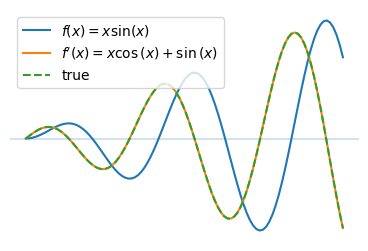

In [ ]:
import sys
sys.setrecursionlimit(2000) 
# --- Node Creaiton Functions
def Const(value):
    """Creates a Constant node. Value can be scalar or NumPy array."""
    # Store value as a NumPy array for consistency, allow object dtype for flexibility if needed
    val_arr = np.array(value, dtype=float) # Ensure float
    return {'op': 'const', 'in': [val_arr], 'out': None, 'grad': 0.0} # Grad initialized scalar

def Variable(name="x"):
    """Creates a Variable node - placeholder for vector/scalar input."""
    # Shape is unknown until evaluate is called
    return {'op': 'variable', 'name': name, 'in': [], 'out': None, 'grad': 0.0} # Grad initialized scalar

def Add(x, y):
    if not (isinstance(x, dict) and isinstance(y, dict)):
        raise TypeError("Inputs to Add must be nodes.")
    return {'op': 'add', 'in': [x, y], 'out': None, 'grad': 0.0}

def Times(x, y):
    if not (isinstance(x, dict) and isinstance(y, dict)):
        raise TypeError("Inputs to Times must be nodes.")
    return {'op': 'times', 'in': [x, y], 'out': None, 'grad': 0.0}

def Sin(x):
    if not isinstance(x, dict):
         raise TypeError("Input to Sin must be a node.")
    return {'op': 'sin', 'in': [x], 'out': None, 'grad': 0.0}


# --- Core Logic Functions ---

def forward(node):
    """Compute the output value (potentially NumPy array) of a node."""
    if node['out'] is not None:
        return node['out']

    if node['op'] == 'const':
        # Constant value is pre-stored (already a numpy array)
        node['out'] = node['in'][0]
    elif node['op'] == 'variable':
        # Value ('out') must be set externally by evaluate() before calling forward
        if node['out'] is None:
             raise ValueError(f"Variable node '{node.get('name')}' value not set before forward pass.")
    elif node['op'] == 'add':
        if len(node['in']) != 2: raise ValueError("Add node needs 2 inputs")
        val1 = forward(node['in'][0])
        val2 = forward(node['in'][1])
        if val1 is None or val2 is None: raise RuntimeError("Input node value missing for Add")
        # NumPy handles element-wise addition and broadcasting
        node['out'] = val1 + val2
    elif node['op'] == 'times':
        if len(node['in']) != 2: raise ValueError("Times node needs 2 inputs")
        val1 = forward(node['in'][0])
        val2 = forward(node['in'][1])
        if val1 is None or val2 is None: raise RuntimeError("Input node value missing for Times")
        # NumPy handles element-wise multiplication and broadcasting
        node['out'] = val1 * val2
    elif node['op'] == 'sin':
        if len(node['in']) != 1: raise ValueError("Sin node needs 1 input")
        input_val = forward(node['in'][0])
        if input_val is None: raise RuntimeError("Input node value missing for Sin")
        # Use NumPy's sin for element-wise operation
        node['out'] = np.sin(input_val)
    else:
        raise TypeError(f"Unknown operation type: {node['op']}")

    if node['out'] is None:
         raise RuntimeError(f"Failed to compute output for node {node}")

    return node['out']


def backward(out_node):
    """Backpropagate gradients through the graph."""
    order = topological_sort(out_node)
    order.reverse()

    for node in order:
        grad_incoming = node['grad']

        if isinstance(grad_incoming, np.ndarray):
            if np.all(grad_incoming == 0):
                continue
        elif grad_incoming == 0.0:
             continue

        def accumulate_grad(target_node, grad_to_add):

            if isinstance(target_node['grad'], (int, float)) and target_node['grad'] == 0.0:
                 target_node['grad'] = np.zeros_like(grad_to_add)

            target_node['grad'] += grad_to_add


        if node['op'] == 'add':
            if len(node['in']) != 2: continue
            # Add distributes gradient equally (element-wise)
            accumulate_grad(node['in'][0], grad_incoming)
            accumulate_grad(node['in'][1], grad_incoming)
        elif node['op'] == 'times':
            if len(node['in']) != 2: continue
            in0, in1 = node['in'][0], node['in'][1]
            if in0['out'] is None or in1['out'] is None: raise ValueError("Forward pass incomplete")
            # Chain rule using element-wise multiplication (NumPy handles it)
            accumulate_grad(in0, in1['out'] * grad_incoming)
            accumulate_grad(in1, in0['out'] * grad_incoming)
        elif node['op'] == 'sin':
            if len(node['in']) != 1: continue
            input_node = node['in'][0]
            if input_node['out'] is None: raise ValueError("Forward pass incomplete")
            # Chain rule: dL/dx = dL/dy * dy/dx = grad_incoming * cos(x)
            local_grad = np.cos(input_node['out']) # Use NumPy's cos
            accumulate_grad(input_node, grad_incoming * local_grad)
        elif node['op'] == 'const' or node['op'] == 'variable':
            pass # Gradients accumulate but don't propagate further

def topological_sort(node, visited=None, order=None):
    """Topological sort (unchanged, works with node structure)."""
    if visited is None: visited = set()
    if order is None: order = []
    node_id = id(node)
    if node_id not in visited:
        visited.add(node_id)
        if node['op'] in ['add', 'times', 'sin']: # Add other vector ops here
            for input_node in node['in']:
                 if isinstance(input_node, dict) and 'op' in input_node:
                    topological_sort(input_node, visited, order)
        order.append(node)
    return order

def evaluate(x_val, var_node, out_node):
    """Evaluate vector function and its gradient w.r.t. var_node."""

    processed_reset = set()
    def reset_graph_state(node):
        node_id = id(node)
        if node_id in processed_reset: return
        processed_reset.add(node_id)
        node['out'] = None
        # Reset gradient to scalar 0.0. It will be converted to array in backward if needed.
        node['grad'] = 0.0
        if node['op'] in ['add', 'times', 'sin']: # Add other vector ops here
            for input_node in node['in']:
                 if isinstance(input_node, dict) and 'op' in input_node:
                    reset_graph_state(input_node)
        # Ensure variable node itself is reset if encountered
        elif node['op'] == 'variable': # Don't check for 'is not var_node' here, reset all
             pass # Already reset above

    # 1. Reset state
    reset_graph_state(out_node)
    reset_graph_state(var_node) # Ensure var_node is reset

    # 2. Forward pass
    if var_node['op'] != 'variable':
        raise TypeError("The node 'var_node' must be of type 'variable'.")
    # Ensure input is a NumPy array of floats
    var_node['out'] = np.array(x_val, dtype=float)

    forward(out_node) # Compute forward pass

    output_value = out_node['out']
    if output_value is None:
        raise RuntimeError("Forward pass did not compute the output value.")

    # 3. Backward pass
    if isinstance(output_value, np.ndarray):
        out_node['grad'] = np.ones_like(output_value, dtype=float)
    else: # Should be scalar if not ndarray
        out_node['grad'] = 1.0

    backward(out_node)

    # 4. Return final value and gradient at the input variable
    return [output_value, var_node['grad']]

x = Variable('x') # Use Variable for the input point
graph = Times(x, Sin(x)) # x*x + x

# evaluate the function and its gradient at a=3
value, grad = evaluate(x_, x, graph) 

print(f"f(x) = {value[3]}, expected: {cos(x_[1])} at idx=1")    
print(f"f'(x) = {grad[3]}, expected: {true_dif(x_[1])} at idx=1")    
print(f"\nThe original derivative is exactly the same as the auto-diff: {(true_dif(x_)[-1] == grad[-1])}")
plt.plot(x_, value, label=r"$f(x) = x \sin(x)$")
plt.plot(x_, grad, label=rf"$f'(x) = {sympy.latex(f_prime)}$")
plt.plot(x_, true_dif(x_), '--', label='true')
plt.axhline(0, alpha=0.2)
plt.legend()
plt.axis(False);


### Limitations
We'll get lack of space due to the intermediate values that auto-diff need to be computed, for this exist a solution calles _checkpointing_, training the largest neural networks requires far more fast storage than is available to a sinlge computer.

However, the forward-backward approach can limit the system’s potential performance. The forward pass is relatively easy to optimize via parallelizing, vectorizing, and distributing graph traversal. The backward pass, on the other hand, is harder to parallelize, as it requires a topological traversal and coordinated gradient accumulation.

Because the backward pass is hard to parallelize as it requires topological traversal and coordinated gradient accumulation. We don't get back a _representation_ of $\nabla f$. If we wanted the gradient of the gradient (hessian) we're out of luck.